In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('Final.csv')

In [3]:
data_list = data.values.tolist()

In [4]:
item_list = []

for i in data_list:
    item_list.append(list(map(str,i)))

In [5]:
data = data.astype(float)

In [6]:
data = data.applymap(str)

# Word2Vec

In [7]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile

In [8]:
path = get_tmpfile('word2vec.model')

In [9]:
model = Word2Vec(item_list, size=1 ,window=5, min_count=1,workers=5)
model.save('word2vec.model')

In [10]:
model = Word2Vec.load('word2vec.model')

In [11]:
word_vectors = model.wv  
vocabs = word_vectors.vocab.keys() #vocabs has keys that is item number

#word_vectors_list has values that is vector value from item number
word_vectors_list = [word_vectors[v] for v in vocabs] 

In [12]:
for i in range(len(data)):            #word2vec value를 data로 넣음
    for j in range(len(data.iloc[i])):
        key=str(data.iloc[i,j])
        data.iloc[i,j] = word_vectors[key].tolist()[0]

In [13]:
data = data.apply(pd.to_numeric)

# {item_id : word2vec} 벡터값과 아이템넘버 맞추기

In [14]:
num_vec = {}

In [15]:
item_id = word_vectors.vocab

In [16]:
item_num = []
for i in item_id.keys():
    item_num.append(i)

In [17]:
item_vec = []
for i in vocabs:
    item_vec.append(word_vectors[i][0])

In [18]:
num_vec = num_vec.fromkeys(item_vec)

In [19]:
j = 0
for i in num_vec.keys():
    num_vec[i] = item_num[j]
    j = j+1

# Data split && Learning

In [20]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from heapq import nsmallest
import time

# 학습데이터와 테스트데이터

In [21]:
X_data = data.drop('13',axis=1)
y_data = data['13']
print(X_data.head())
print(X_data.shape)

          0         1         2         3         4         5         6  \
0 -0.673092 -0.767208 -0.754473 -0.767208 -0.757247 -0.767208 -0.768221   
1 -0.464439 -0.518068 -0.518068 -0.536233 -0.518068 -0.523037 -0.536233   
2 -3.326532 -1.932247 -1.529899 -2.107408 -2.728838 -1.580990 -2.162528   
3 -3.326532 -2.242144 -1.935960 -1.991401 -1.265548 -1.359664 -2.920877   
4 -1.129507 -1.260457 -1.260457 -1.274987 -1.286799 -1.262502 -1.262502   

          7         8         9        10        11        12  
0 -0.754473 -0.757247 -0.757247 -0.767208 -0.768221 -0.757247  
1 -0.536233 -0.523037 -0.523037 -0.523037 -0.523037 -0.518068  
2 -2.106616 -2.549870 -1.630203 -1.585553 -1.602095 -2.140919  
3 -2.920877 -1.889275 -1.581453 -3.072871 -1.687228 -2.089056  
4 -1.265346 -1.251907 -1.267736 -1.286799 -1.265346 -1.260457  
(10000, 13)


# 데이터 확인

In [22]:
seed = 0
test_size = 0.2
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=0.2, random_state=seed)

print(X_train.shape)
print(X_test.shape)

(8000, 13)
(2000, 13)


In [23]:
start = time.time()

model = xgb.XGBClassifier(n_estimators=500,max_depth=8,learning_rate=0.05,subsample=0.5)
model.fit(X_train,y_train)

end = time.time()
print("학습하는데 걸린 시간(분):", (end-start)/60)

학습하는데 걸린 시간(분): 46.06496846278508


In [24]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
params = {
    "Objective": 'gbtree',
    "eval_metric": 'rmse',
    "eta" : 0.1 #learning late
}
cv = xgb.cv(params=params, dtrain=dtrain, num_boost_round=100, nfold=5,
            seed=41, early_stopping_rounds= 100)

In [25]:
cv

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.502638,0.003926,1.502659,0.016017
1,1.353343,0.003524,1.353477,0.014381
2,1.218963,0.003167,1.219002,0.012835
3,1.098004,0.002851,1.098270,0.011506
4,0.989069,0.002519,0.989461,0.010158
...,...,...,...,...
95,0.007609,0.000681,0.043715,0.010669
96,0.007507,0.000637,0.043699,0.010712
97,0.007424,0.000651,0.043704,0.010733
98,0.007345,0.000639,0.043672,0.010739


# 추천 정확도 (TC2)

1 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9445
----------------------------------------------------
2 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9425
----------------------------------------------------
3 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9405
----------------------------------------------------
4 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9365
----------------------------------------------------
5 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9455
----------------------------------------------------
6 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.941
----------------------------------------------------
7 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9435
----------------------------------------------------
8 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9385
----------------------------------------------------
9 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9375
----------------------------------------------------
10 번째 추천 시작
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9345
-------------------------------------------

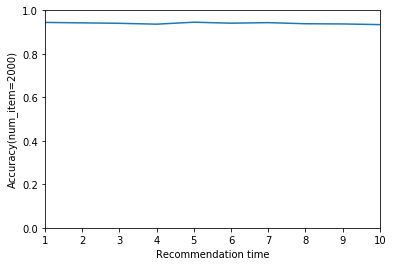

In [26]:
avg_acu = [0]

for i in range(1, 11):
    print(i, "번째 추천 시작")
    
    result = pd.DataFrame()
    seed = i
    X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=test_size, random_state=seed)
    prediction = model.predict(X_test)
    
    result['predicted'] = prediction
    result['Y_test'] = y_test.tolist()
    
    #예측값과 근사한 값 5개 출력
    vector_list = []

    for i in range(len(result)):
        vector_list.append(nsmallest(5, word_vectors_list, key=lambda x: abs(x-result['predicted'].iloc[i])))
    
    result['Nearby5'] = pd.Series(vector_list)
    
    for i in range(len(result)):
        result['Nearby5'].iloc[i] = vector_list[i]
    
    T_F = []
    for i in range(len(result)):
        if result['Y_test'].iloc[i] in result['Nearby5'].iloc[i]:
            T_F.append('True')
        else:
            T_F.append('False')
    
    result['T_F'] = T_F
    
    print("예측한 값과 가까운 아이템 5개의 Accuracy :", len(result[result['T_F']=='True'])/len(result))
    
    
    avg_acu.append(len(result[result['T_F']=='True'])/len(result))

    
    print("----------------------------------------------------")

print("추천 정확도의 평균 :", sum(avg_acu[1:])/len(avg_acu[1:]))

import matplotlib.pyplot as plt

plt.plot(avg_acu)
plt.xlabel("Recommendation time")
plt.ylabel("Accuracy(num_item=2000)")
plt.xlim(1,10)
plt.ylim(0,1)
plt.rcParams["figure.figsize"] = 10, 6
plt.show()

# 추천 시간 (TC3)

In [ ]:
avg_time = [0]

for i in range(1, 11):
    print(i, "번째 추천 시작")
    
    result = pd.DataFrame()
    start = time.time()
    seed = i
    X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=test_size, random_state=seed)
    prediction = model.predict(X_test)
    
    
    result['predicted'] = prediction
    result['Y_test'] = y_test.tolist()
    
    #예측값과 근사한 값 5개 출력
    vector_list = []

    for i in range(len(result)):
        vector_list.append(nsmallest(5, word_vectors_list, key=lambda x: abs(x-result['predicted'].iloc[i])))
    
    result['Nearby5'] = pd.Series(vector_list)
    
    for i in range(len(result)):
        result['Nearby5'].iloc[i] = vector_list[i]
    
    T_F = []
    for i in range(len(result)):
        if result['Y_test'].iloc[i] in result['Nearby5'].iloc[i]:
            T_F.append('True')
        else:
            T_F.append('False')
    
    result['T_F'] = T_F
    
    end = time.time()
    
    print("추천(2000건)에 걸린 시간(초):", end-start)
    print("데이터 한개당 걸린 시간 :", (end-start)/2000)
    
    
    avg_acu.append(len(result[result['T_F']=='True'])/len(result))

    
    avg_time.append((end - start)/2000)
    print("----------------------------------------------------")

print("데이터 한개당 걸린 시간의 평균 :", sum(avg_time[1:])/len(avg_time[1:]))

import matplotlib.pyplot as plt

plt.plot(avg_time)
plt.xlabel("Recommendation time")
plt.ylabel("Take time per item(sec)")
plt.xlim(1,10)
plt.ylim(0,0.1)
plt.rcParams["figure.figsize"] = 10, 6
plt.show()

1 번째 추천 시작


# 쇼핑 패턴에서 나온 최종 추천 아이템 5개

In [ ]:
total_list = []
for i in range(len(result)):
    vector_list = []
    for j in range(5):
        vector_list.append(nsmallest(5, word_vectors_list, key=lambda x: abs(x-result['predicted'].iloc[i]))[j][0])
    total_list.append(vector_list)

In [ ]:
real_itemnum = []
for i in range(len(total_list)):
    real_item = []
    for j in range(5):
        real_item.append(num_vec[total_list[i][j]])
    real_itemnum.append(real_item)

In [ ]:
result['Item5'] = real_itemnum

In [ ]:
result

In [ ]:
real_itemnum